# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

This Jupyter notebook allows you to run Q3Dfit, a PSF decomposition and spectral analysis package tailored for JWST NIRSpec and MIRI IFU observations. 

Q3Dfit is developed as a science-enabling data product by the Early Release Science Team #1335 Q3D. You can find more information about this ERS program **Q3D** [here](https://wwwstaff.ari.uni-heidelberg.de/dwylezalek/q3d.html) and [here](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1335).

The software is based on the existing package IFSFIT developed by Dave Rupke (see [ADS link](https://ui.adsabs.harvard.edu/abs/2017ApJ...850...40R/abstract)).

The following notebook will guide you through the initialization procedure and will then perform the analysis. 

## Table of Contents

* [1. Initialization](#chapter1)
    * [1.1. Setting up the directory tree](#chapter1_1)
    * [1.2. Setting up the fitting parameters](#chapter1_2)
        * [1.2.3. Line ratio constraints](#chapter1_2_3)
    * [1.3. Setting up the plotting parameters](#chapter1_3)
* [2. Run Q3Dfit](#chapter2)
* [3. Run plotting script (q3da)](#chapter3)

<font color='red'>We need to decide where the makeqsotemplate functionality goes. </font>

## 1. Initialization <a class="anchor" id="chapter1"></a>

In [1]:
import os.path
import numpy as np

### 1.1. Setting up the directory tree <a class="anchor" id="chapter1_1"></a>

Define the directories in which your data cube(s) that you want to analyse are stored and the output directories. We recommend creating a working directory that you name after your target, in which all outputs from Q3Dfit will be saved. 

In [2]:
# book-keeping variables (optional; for this box only)
volume = '' # base directory
gal = 'nirspec-etc' # prefix label for output files

# Input files
infile = volume+'nirspec_etc_cube_both.fits' # path + name of your input cube
qsotemplate = volume+'nirspec_ETC_QSO.npy' 
#stellartemplates = volume+gal+'hosttemplate.npy'

# Output directories/files
outdir = volume+'' # path + name of directory for saving the output files
path_to_npy_file = volume+'' # path for initproc.npy
logfile = outdir+gal+'_fitlog.txt'

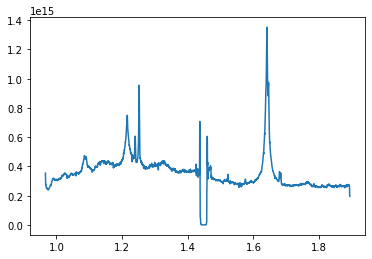

In [72]:
volume = '/Users/drupke/Box Sync/q3d/simulations/NIRSPEC/Oct_2021/' # base directory
gal = 'nirspec-fullsim' # prefix label for output files

# Input files
infile = volume+'NRS00001-QG-F100LP-G140H_comb_1234_noutlier_g140h-f100lp_s3d.fits' # path + name of your input cube
from q3dfit.common.makeqsotemplate import makeqsotemplate
qsotemplate = volume+'nirspec-fullsim-qso.npy' 
templateinfile = '/Users/drupke/Box Sync/q3d/simulations/NIRSPEC/May_2021/NRS00001-QG-F100LP-G140H_comb_1234_g140h-f100lp_s3d.fits'
makeqsotemplate(templateinfile, qsotemplate , datext=1, varext=2, dqext=3, wmapext=4, radius=3)
#stellartemplates = volume+gal+'hosttemplate.npy'

# Output directories/files
outdir = '/Users/drupke/specfits/q3dfit/testing/nirspec-fullsim/'
path_to_npy_file = outdir
logfile = outdir+gal+'_fitlog.txt'

Some general information about your cube:

In [56]:
ncols = 37 # number of columns
nrows = 43 # number of rows
fitrange = [0.98,1.40] #1.80] #in um

if not os.path.isfile(infile): 
    print('Data cube not found.')

### 1.2. Setting up the fitting parameters <a class="anchor" id="chapter1_2"></a>

What lines do you want to fit? You can choose from the linelist <font color='red'>provide reference here</font>.

In [57]:
lines = ['Hbeta', '[OIII]4959', '[OIII]5007']

How many components do you want to be fitted to the emission lines?

In [58]:
maxncomp = 1

In [59]:
# Initialize line ties, n_comps, z_inits, and sig_inits.
linetie = dict()
ncomp = dict()
zinit_gas = dict()
siginit_gas = dict()
for i in lines:
    linetie[i] = '[OIII]5007'
    ncomp[i] = np.full((ncols,nrows),maxncomp)
    zinit_gas[i] = np.full((ncols,nrows,maxncomp),1.500)
    siginit_gas[i] = np.full(maxncomp,50.)

`siglim_gas` sets lower and upper bounds for the Gaussian width (sigma) of the emission line. These limits can be set globablly, for all spaxels and components, by defining a 2-element array. The limits can also be set for individual spaxels (but all components) by defining an (Ncol x Nrow x 2) array.

In [60]:
# Global limit
siglim_gas = np.array([5., 1000.])

# Spaxel-by-spaxel limit
# siglim_gas = np.ndarray((dx, dy, 2))
# siglim_gas[:,:,] = array([5.,1000.])
# siglim_gas[13, 10, :] = array([5.,500.])

Description of continuum fitting parameters:
- `hostord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `hostord`. 0 < hostord < 4
- `qsoord` = [Optional] additive Legendre polynomial for host [starlight] component. Adds components up to order `qsoord`. 0 < hostord < 4

In [61]:
fcncontfit = 'fitqsohost'
argscontfit = dict()
#argscontfit['blrpar'] = [0., 1.6400, 0.5000/299792.*1.6400,
#                         0., 1.2150, 0.5000/299792.*1.2150]
argscontfit['qsoxdr'] = qsotemplate
#argscontfit['qsoord'] = 3
#argscontfit['hostord'] = 10
#argscontfit['refit'] = 'ppxf'

#### 1.2.3. Line ratio constraints <a class="anchor" id="chapter1_2_3"></a>
`line1`, `line2`, and `comp` are required. `value` is the initial value of `line1`/`line2`, and `lower` and `upper` limits can also be specified. (If they are not, and the line pair is a doublet in the doublets.tbl file, then the lower and upper limits are set using the data in that file.) The ratio can also be `fixed`.

In [62]:
# Required columns:
#line1 = ['[NI]5198']
#line2 = ['[NI]5200']
#comp = np.array([0], dtype=np.int32)

# Optional columns:
#value = [1.5]
#fixed = [True]
# lower = []
# upper = []

# Write table
#from astropy.table import QTable
#lineratio = QTable([line1, line2, comp, value, fixed], names=['line1', 'line2', 'comp', 'value', 'fixed'])

### 1.3. Setting up the plotting parameters <a class="anchor" id="chapter1_3"></a>

One dictionary must be defined for a line plot to appear. `argspltlin1` holds the options for the first line plot, and `argspltlin2` is for the second. Parameter options are fed in as keyword/data pairs.

Required keywords in each dictionary:
* `nx`: Number of subplots in the horizontal direction
* `ny`: Number of subplots in the vertical direction
* Options for centerting the plot:
    - `line`: a string list of line labels
    - `center_obs`: a float list of wavelengths of each subplot center, in the observed (plotted) frame
    - `center_rest`: a float list of wavelengths of each subplot center, in the rest frame, which are converted to obs. frame

Optional keywords:
* `size`: float list of widths in wavelength space of each subplot; if not specified, default is 300 $Å$
* `IR`: set to `True` to use infrared-style plot

In [63]:
argspltlin1 = {'nx': 2,
               'ny': 1,
               'line': ['Hbeta', '[OIII]5007'],
               'size': [0.05, 0.05]}

The following cell will create the initialisation structure. **Do not change anything in this cell.** 

In [67]:
initproc = { \
        # Required pars
        'fitran': fitrange,
        'fluxunits': 1,
        'infile': infile,
        'label': gal,
        'lines': lines,
        'linetie': linetie,
        'maxncomp': maxncomp,
        'name': 'PG1411+442',
        'ncomp': ncomp,
        'outdir': outdir,
        'zinit_gas': zinit_gas,
        'zsys_gas': 1.500,
        # Optional pars
        'argscheckcomp': {'sigcut': 0.1},
        'fcncontfit': fcncontfit,
        'argscontfit': argscontfit,
        'argscontplot': {'xstyle': 'lin',
                         'ystyle': 'lin',
                         'fluxunit_in': 'flambda',
                         'fluxunit_out': 'flambda',
                         'mode': 'dark'},
        'argsreadcube': {'wmapext': None, 'error': True},
        'argspltlin1': argspltlin1,
        #'argslinfit': {'ftol': 1e-6, 'xtol': 1e-6}
        #'decompose_qso_fit': 1,
        #'remove_scattered': 1,
        'fcncheckcomp': 'checkcomp',
        'maskwidths_def': 500.,
        #'emlsigcut': ,
        'logfile': logfile,
        'siglim_gas': siglim_gas,
        'siginit_gas': siginit_gas,
        #'cutrange': np.array([1.40,1.49]),
        'nocvdf': 1,
    }

If you want to run `q3dfit` in batch mode, run this cell, which saves initproc to an `npy` file. In your python command line, read in that `npy` file with
<pre><code>import numpy as np
initproc = np.load('path/to/the/npy/file/initproc.npy',allow_pickle=True)</code></pre>
and then run `q3dfit` with 
<pre><code>from q3dfit.common.q3df
import q3df q3df(initproc[()],cols=cols,rows=rows)</code></pre>

In [68]:
initproc_npy = 'initproc.npy'
np.save(path_to_npy_file+initproc_npy,initproc)

## 2. Run Q3Dfit <a class="anchor" id="chapter2"></a>

In [27]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

In [28]:
cols = 22
rows = 20

In [42]:
q3df(initproc,cols=cols,rows=rows)

FITLOOP: First call to FITSPEC
FITLOOP: Setting 260.000000 points from zero/inf flux or neg/zero/inf error to np.nan
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0912e+10                                    1.57e+13    
       1              2         3.0415e+10      4.97e+08       1.73e-05       1.56e+13    
       2              3         2.9434e+10      9.82e+08       3.46e-05       1.53e+13    
       3              4         2.7522e+10      1.91e+09       6.93e-05       1.48e+13    
       4              5         2.3907e+10      3.62e+09       1.39e-04       1.37e+13    
       5              6         1.7505e+10      6.40e+09       2.77e-04       1.16e+13    
       6              7         7.9997e+09      9.50e+09       5.54e-04       7.30e+12    
       7              8         1.8582e+09      6.14e+09       9.30e-04       1.65e+11    
       8              9         1.8258e+09      3.24e+07       6

      91             102        3.1876e+08      3.21e+03       6.01e-06       2.72e+08    
      92             103        3.1847e+08      2.90e+05       1.09e-02       1.46e+10    
      93             104        3.1844e+08      2.51e+04       4.71e-06       7.74e+08    
      94             105        3.1844e+08      6.96e+03       9.38e-05       5.49e+08    
      95             107        3.1827e+08      1.72e+05       5.86e-03       3.35e+09    
      96             108        3.1826e+08      2.55e+03       4.46e-06       2.76e+08    
      97             109        3.1800e+08      2.63e+05       1.15e-02       1.56e+10    
      98             110        3.1797e+08      2.88e+04       5.37e-06       8.76e+08    
      99             111        3.1797e+08      5.18e+03       6.83e-05       6.29e+08    
      100            113        3.1780e+08      1.67e+05       5.94e-03       2.91e+09    
      101            114        3.1780e+08      2.54e+03       5.00e-06       2.79e+08    

      186            200        3.0960e+08      1.91e+04       6.44e-03       1.03e+09    
      187            201        3.0958e+08      1.77e+04       6.48e-03       9.99e+08    
      188            202        3.0956e+08      1.66e+04       6.65e-03       9.71e+08    
      189            203        3.0955e+08      1.50e+04       6.62e-03       9.45e+08    
      190            204        3.0953e+08      1.24e+04       6.03e-03       9.13e+08    
      191            205        3.0952e+08      1.33e+04       7.34e-03       9.07e+08    
      192            206        3.0951e+08      9.30e+03       5.82e-03       8.93e+08    
      193            207        3.0950e+08      1.02e+04       7.52e-03       9.32e+08    
      194            208        3.0949e+08      7.74e+03       6.96e-03       9.44e+08    
      195            209        3.0949e+08      6.15e+03       7.07e-03       9.52e+08    
      196            210        3.0948e+08      4.49e+03       7.18e-03       9.60e+08    

      12             13         1.5092e+09      9.18e+07       4.65e-03       2.77e+10    
      13             14         1.5089e+09      2.18e+05       1.79e-05       2.76e+10    
      14             15         1.5089e+09      8.41e+04       3.61e-06       3.03e+09    
      15             16         1.3477e+09      1.61e+08       1.44e-02       1.50e+10    
      16             17         1.3476e+09      6.46e+04       4.93e-06       1.50e+10    
      17             18         1.3476e+09      3.49e+04       4.06e-06       2.89e+09    
      18             19         1.2192e+09      1.28e+08       3.50e-02       3.19e+10    
      19             20         1.0317e+09      1.87e+08       7.09e-02       5.61e+10    
      20             21         8.5556e+08      1.76e+08       7.74e-02       7.65e+10    
      21             22         7.2789e+08      1.28e+08       6.48e-02       7.57e+10    
      22             23         5.8601e+08      1.42e+08       8.10e-02       3.15e+10    

      104            116        3.6551e+08      1.04e+05       3.87e-06       1.81e+09    
      105            117        3.6551e+08      1.04e+03       7.70e-06       1.67e+09    
      106            118        3.6515e+08      3.56e+05       1.62e-02       2.77e+10    
      107            119        3.6507e+08      8.13e+04       7.62e-06       1.80e+09    
      108            120        3.6507e+08      9.74e+02       5.18e-06       1.63e+09    
      109            121        3.6471e+08      3.60e+05       1.63e-02       2.46e+10    
      110            122        3.6465e+08      6.41e+04       6.18e-06       1.71e+09    
      111            123        3.6465e+08      7.40e+02       3.48e-06       1.55e+09    
      112            124        3.6429e+08      3.60e+05       1.63e-02       2.19e+10    
      113            125        3.6423e+08      5.12e+04       5.72e-06       1.62e+09    
      114            126        3.6423e+08      5.42e+02       4.61e-07       1.39e+09    

      199            215        3.5667e+08      8.00e+03       8.12e-03       9.55e+08    
      200            216        3.5667e+08      5.55e+03       8.27e-03       9.20e+08    
      201            217        3.5667e+08      2.98e+03       8.31e-03       8.96e+08    
      202            218        3.5667e+08      3.75e+02       8.43e-03       9.20e+08    
      203            219        3.5666e+08      4.98e+02       6.02e-04       6.59e+08    
      204            220        3.5666e+08      4.15e+02       1.03e-03       3.40e+08    
      205            221        3.5666e+08      1.58e+02       1.55e-03       9.96e+07    
      206            223        3.5666e+08      7.88e+00       4.42e-04       1.06e+06    
      207            224        3.5666e+08      2.17e+00       4.82e-04       8.35e+05    
`ftol` termination condition is satisfied.
Function evaluations 224, initial cost 3.1984e+10, final cost 3.5666e+08, first-order optimality 8.35e+05.
[[Variables]]
    stars_add_exp

       2              3         3.0726e+10      1.03e+09       3.46e-05       1.61e+13    
       3              4         2.8716e+10      2.01e+09       6.93e-05       1.55e+13    
       4              5         2.4917e+10      3.80e+09       1.39e-04       1.44e+13    
       5              6         1.8199e+10      6.72e+09       2.77e-04       1.21e+13    
       6              7         8.2657e+09      9.93e+09       5.54e-04       7.60e+12    
       7              8         2.0065e+09      6.26e+09       9.11e-04       1.70e+11    
       8              9         1.9731e+09      3.34e+07       6.16e-05       1.12e+09    
       9             10         1.9151e+09      5.81e+07       1.15e-04       1.11e+09    
      10             11         1.8076e+09      1.07e+08       2.69e-04       1.11e+09    
      11             12         1.6248e+09      1.83e+08       8.80e-04       1.53e+09    
      12             13         1.5333e+09      9.15e+07       4.63e-03       2.78e+10    

      93             106        3.7882e+08      1.78e+05       6.87e-03       1.22e+10    
      94             107        3.7880e+08      1.59e+04       1.50e-06       5.22e+08    
      95             108        3.7880e+08      2.73e+02       1.76e-06       4.85e+08    
      96             109        3.7879e+08      1.72e+04       1.37e-02       4.74e+10    
      97             110        3.7855e+08      2.40e+05       5.84e-06       2.09e+09    
      98             111        3.7854e+08      1.85e+03       5.24e-06       1.71e+09    
      99             112        3.7829e+08      2.54e+05       3.41e-03       8.52e+08    
      100            113        3.7829e+08      5.25e+02       2.30e-06       8.52e+08    
      101            114        3.7829e+08      4.08e+02       2.14e-06       8.13e+07    
      102            115        3.7810e+08      1.85e+05       6.86e-03       9.01e+09    
      103            116        3.7809e+08      1.22e+04       1.26e-05       3.66e+08    

      185            201        3.6903e+08      1.25e+05       1.11e-02       1.16e+09    
      186            202        3.6903e+08      2.18e+02       2.38e-07       8.60e+08    
      187            203        3.6891e+08      1.23e+05       1.13e-02       1.16e+09    
      188            204        3.6891e+08      2.26e+02       2.49e-07       8.56e+08    
      189            205        3.6879e+08      1.21e+05       1.17e-02       1.18e+09    
      190            206        3.6879e+08      2.34e+02       2.58e-07       8.56e+08    
      191            207        3.6867e+08      1.17e+05       1.18e-02       1.15e+09    
      192            208        3.6867e+08      2.49e+02       2.87e-07       8.36e+08    
      193            209        3.6855e+08      1.20e+05       1.27e-02       1.25e+09    
      194            210        3.6855e+08      2.50e+02       2.61e-07       8.80e+08    
      195            211        3.6845e+08      1.02e+05       1.13e-02       1.07e+09    

      26             29         3.9243e+08      8.48e+05       4.91e-05       4.98e+08    
      27             30         3.8977e+08      2.66e+06       4.97e-05       1.20e+10    
      28             31         3.8972e+08      5.07e+04       5.04e-05       6.35e+07    
      29             32         3.8857e+08      1.15e+06       2.58e-02       2.92e+09    
      30             33         3.8855e+08      2.02e+04       2.21e-05       1.51e+07    
      31             34         3.8784e+08      7.05e+05       2.58e-02       3.72e+09    
      32             35         3.8783e+08      1.17e+04       1.19e-05       1.48e+08    
      33             36         3.8669e+08      1.14e+06       5.01e-02       9.91e+09    
      34             37         3.8666e+08      3.46e+04       2.10e-05       1.23e+09    
      35             38         3.8530e+08      1.36e+06       9.45e-02       3.13e+10    
      36             39         3.8517e+08      1.28e+05       4.35e-06       6.67e+09    

      120            134        3.7602e+08      1.93e+03       4.37e-06       1.75e+08    
      121            135        3.7575e+08      2.77e+05       1.23e-02       1.47e+10    
      122            136        3.7572e+08      2.32e+04       1.81e-06       1.01e+09    
      123            137        3.7572e+08      3.80e+02       1.80e-06       9.42e+08    
      124            138        3.7546e+08      2.58e+05       2.01e-02       3.74e+10    
      125            139        3.7531e+08      1.50e+05       4.61e-06       2.50e+09    
      126            140        3.7531e+08      1.44e+03       9.02e-07       2.12e+09    
      127            141        3.7502e+08      2.94e+05       2.46e-02       4.79e+10    
      128            142        3.7477e+08      2.46e+05       5.91e-06       3.15e+09    
      129            143        3.7477e+08      2.24e+03       1.13e-06       2.64e+09    
      130            144        3.7433e+08      4.45e+05       2.46e-02       3.95e+10    

      213            229        3.6763e+08      3.20e+04       8.24e-03       9.77e+08    
      214            230        3.6760e+08      3.31e+04       9.33e-03       1.01e+09    
      215            231        3.6759e+08      1.25e+04       3.76e-03       9.22e+08    
      216            232        3.6753e+08      5.29e+04       1.91e-02       1.85e+09    
      217            233        3.6753e+08      4.07e+02       2.89e-07       9.59e+08    
      218            234        3.6751e+08      2.05e+04       8.29e-03       8.65e+08    
      219            235        3.6749e+08      1.78e+04       8.73e-03       8.10e+08    
      220            236        3.6748e+08      1.49e+04       8.75e-03       8.09e+08    
      221            237        3.6747e+08      1.20e+04       8.83e-03       8.32e+08    
      222            238        3.6746e+08      9.12e+03       8.92e-03       8.44e+08    
      223            239        3.6745e+08      6.13e+03       9.00e-03       8.48e+08    

## 3. Run plotting script (q3da) <a class="anchor" id="chapter3"></a>

Inline plotting:

<IPython.core.display.Javascript object>


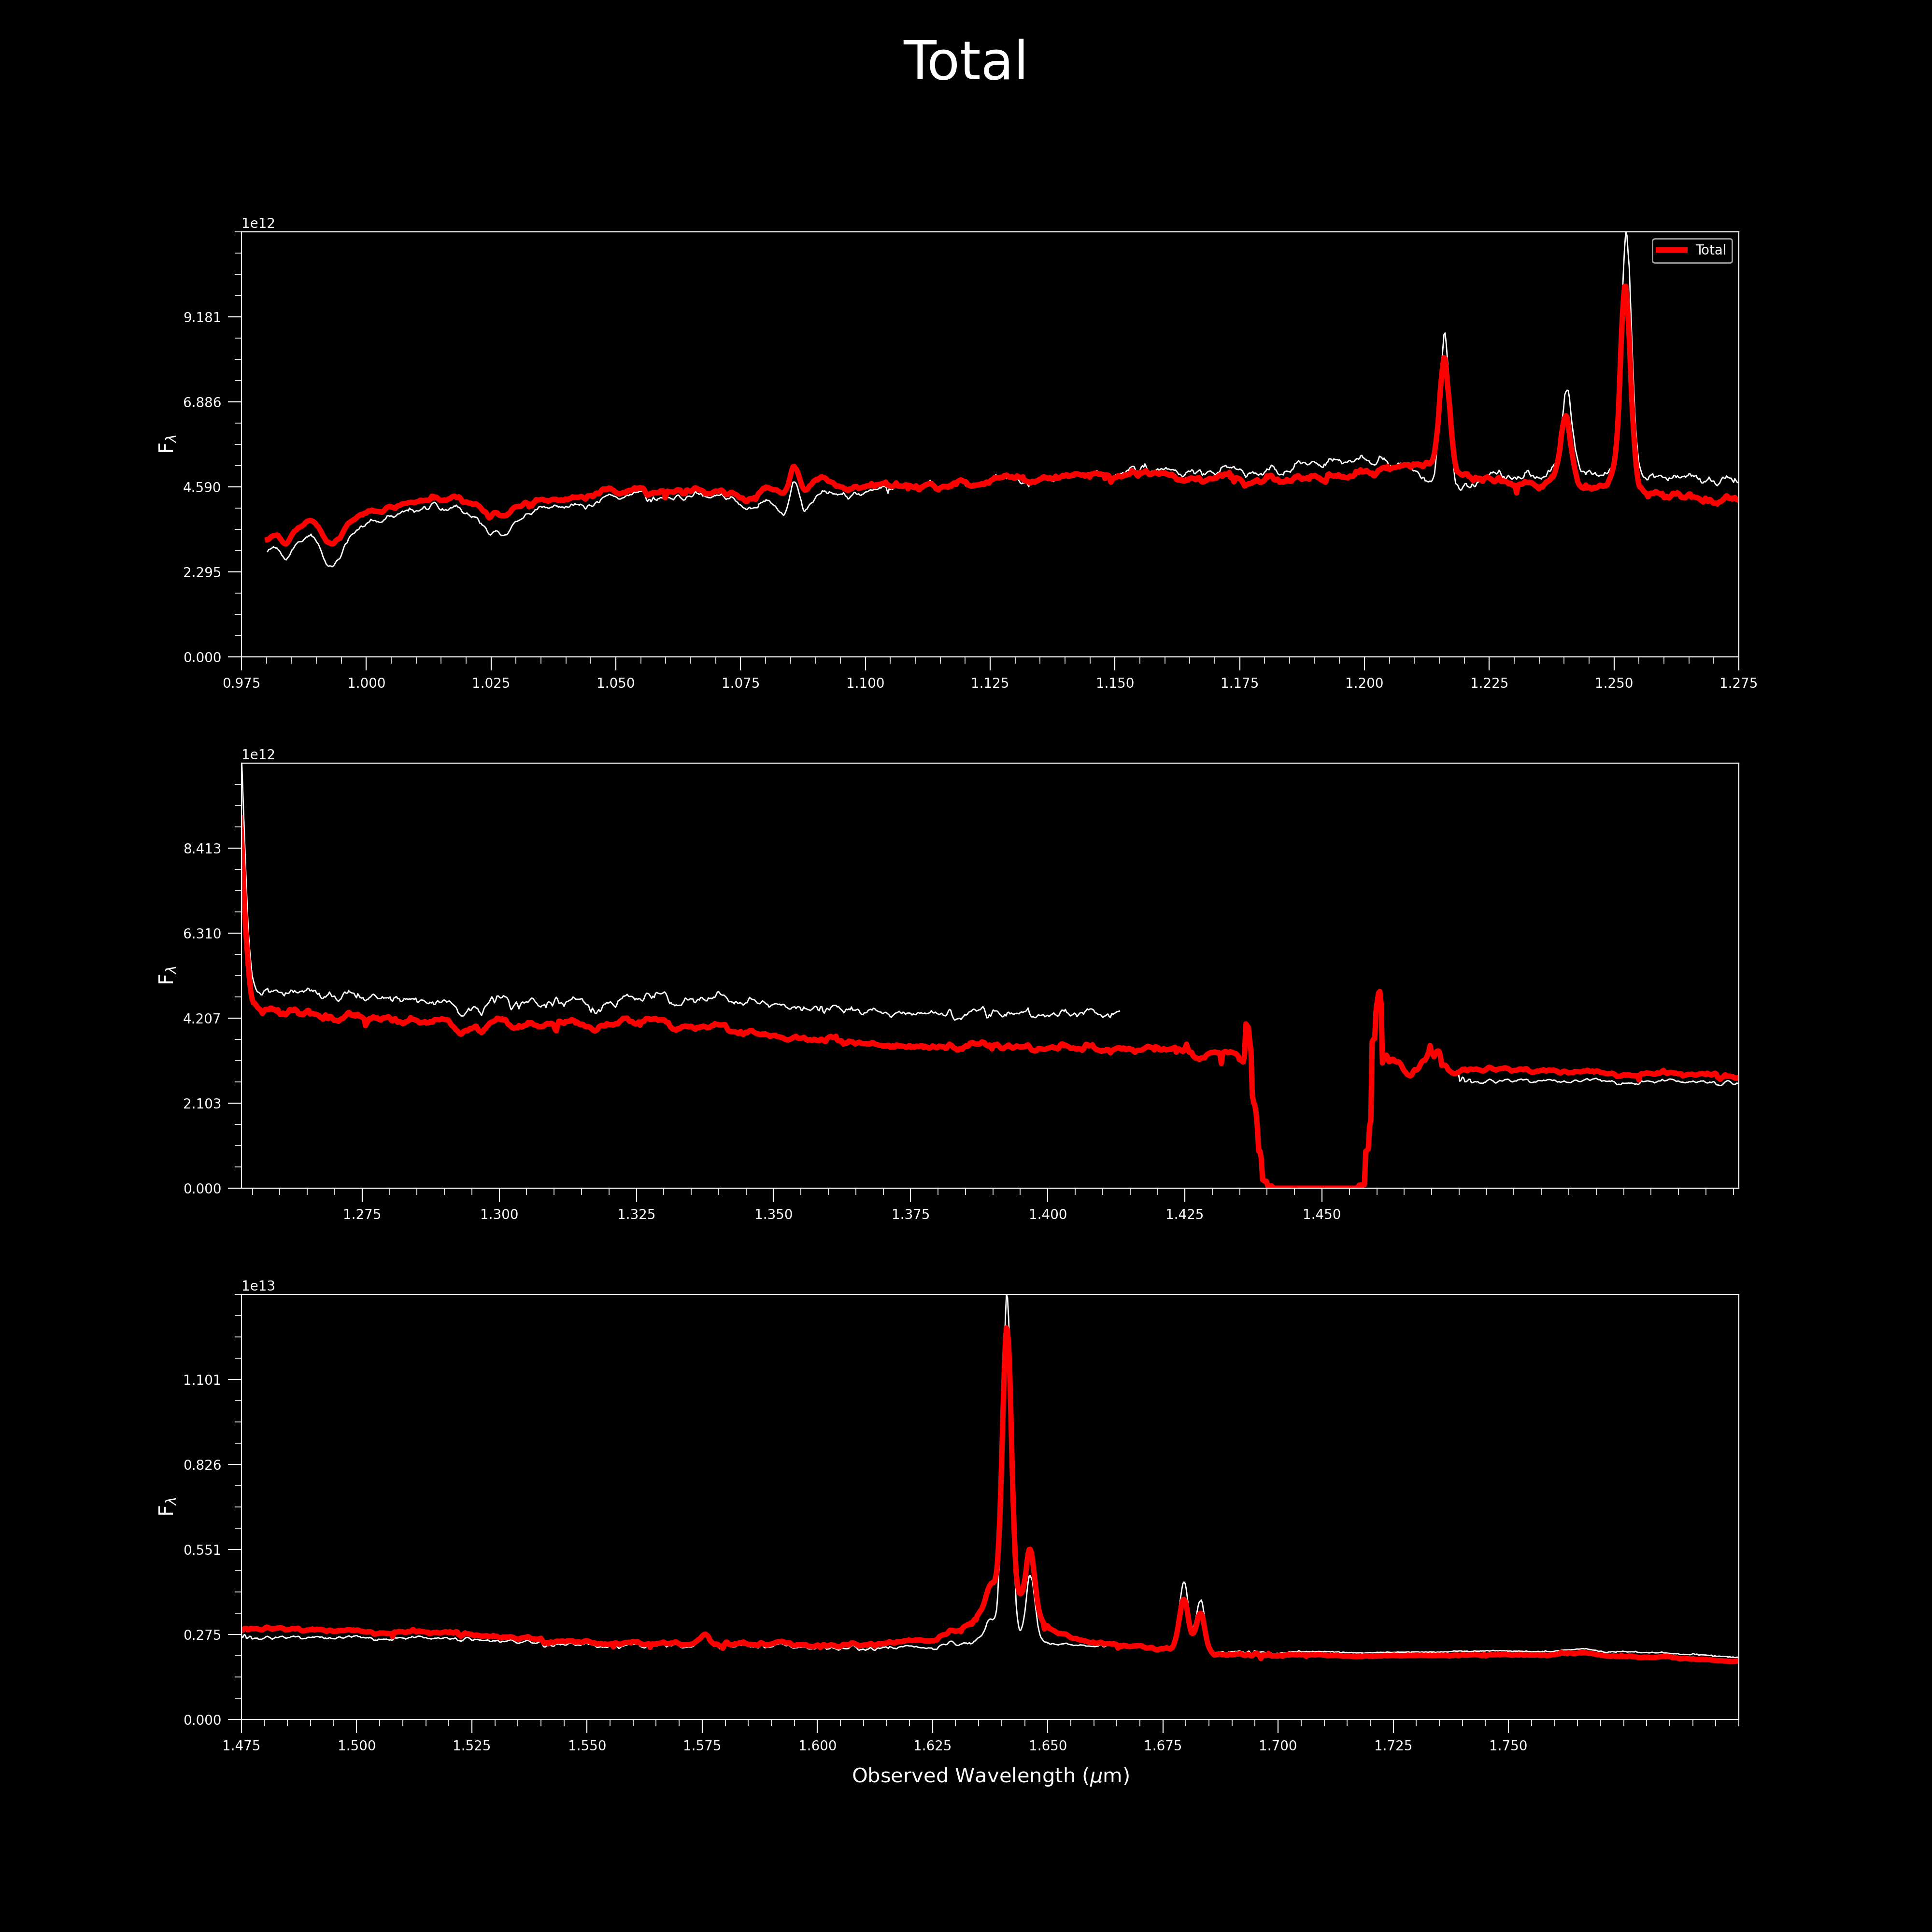

In [43]:
%matplotlib notebook
q3da(initproc,cols=cols,rows=rows)

Plots in an external, interactive window:

In [ ]:
%matplotlib
q3da(initproc,cols=cols,rows=rows)